# Der Effekt der Anime-Konvertierung auf das Bild nach dem Hinzufügen von weißem Rauschen
## Xiaojie Sun, You Zou, Yian Yu
### Seminar: Visuelle Wahrnehmung beim Menschen und Bildqualität - WiSe 2020/21
### Geleitet von Prof. Dr. Marianne Maertens und Dr. Guillermo Aguilar

In [1]:
from PIL import Image # Pillow image library
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d

import pandas as pd
import seaborn as sns
sns.set_style('ticks')
sns.set_context('talk')

## 1. Einleitung

AnimeGan, das 2021 veröffentlicht wurde, ist eine neue Möglichkeit, Fotos von echten Szenen in Anime-Stil umzuwandeln. Es erfüllt eine sinnvolle und herausfordernde Aufgabe in den Bereichen Computer Vision und künstlerischer Stiltransfer. Durch die Beobachtung der Anime-Konvertierung, merken wir, dass die Anime Bildern weniger für menschliche Wahrnehmung wichtige Details enthalten. Dafür haben wir folgenden Fragestellung erstellt:
Unterscheidet sich der Effekt von weißem Rauschen auf die wahrgenommene Bildqualität zwischen Originalbildern und Anime-Bildern?


## 1.1. Hypothese

Um den Detailgrad zu definieren, haben wir zwei Forschungslinien verfolgt: In eine Richtung, Detailgrad verringert sich durch Anime-Konvertierung. Darüber haben wir vermutet, Die Bewertung des Anime ist höher als das Originalbild unter dem gleichen Rauschen im Liniendiagramm jeder Gruppe. In ein andere Richtung, ein Bild kann weniger Details enthalten. Mit anderen Worten, jedes Bild hat einen anderen Detailgrad. Und wir denken, die Bewertung der Gruppe mit einem hohen Detailgrad bei gleichem Rauschlevel schlechter als eine Gruppe mit einem geringen Detailgrad ist. Weil je mehr Details die Originalbilder haben, desto mehr Details gehen bei der Konvertierung verloren, daraus folgt eine schlechter Bewertung.

![](detaildefinition.png)

## 2. Versuchsplan

### 2.1 Variablen und Versuchsbedingung
**Unabhängig Variablen:**
1. 5 Stufen weißes Rauschen: 5,15,25,35,45
2. 3 Gruppen von Bildern: viele Einzelheiten, mäßige viele Einzelheite, wenige Einzelheiten
3. 2 Typen von Bildern: Original & Anime

**Abhängig Variablen:**
Wahrgenommene Bildqualität 
- Für jedes Bild 12 verschiedene Formen -> 6 aus dem Originalbild und 6 aus dem Anime-Bild
- Für jede Gruppe haben wir 10 Bildern -> $3\cdot10\cdot12=360$
- Also insgesamt 360 Durchgänge

### 2.2 Vorbereitung
Um den Unterschied zwischen dem Originalbild und dem Anime-Bild nach AnimeGAN zu quantifizieren, haben wir den mittleren quadratischen Fehler (MSE) zwischen dem Originalbild und dem Anime-Bild berechnet.Die beiden folgenden Bilder haben beispielsweise einen MSE-Wert von 100,68:

MSE 100.682191212972


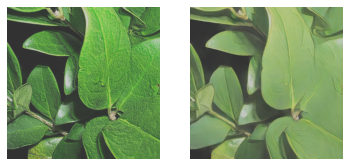

In [63]:
# reading image with PIL module
original = Image.open('orig1p9.png')
anime = Image.open('anig1p9.png')
# converting it to a numpy array. numpy arrays are easier to manipulate 
im_original = np.array(original)
im_anime = np.array(anime)

def mse(im1, im2):
    N = im_original.size 
    return (1.0/N)*np.sum((im1 - im2)**2)
print('MSE', mse(im_original, im_anime))
plt.figure()
plt.subplot(1,2,1)
plt.axis('off')
plt.imshow(im_original)
plt.subplot(1,2,2)
plt.axis('off')
plt.imshow(im_anime)

Wir möchten Unterschiede von Anime Konvertierung minimieren,wie z.B.die mittlere Helligkeit Verschiebung, deshalb verringern wir die Helligkeit der Anime-Bildern, damit wir einzige Variable haben, also die Anzahl von Einzelheiten.

Als nächstes haben wir den rgb-Dreikanal-Durchschnittswert in der mittleren Reihe des Originalbildes und des Anime-Bildes extrahiert und ihren Unterschied visualisiert：


Difference -28.828124999999986


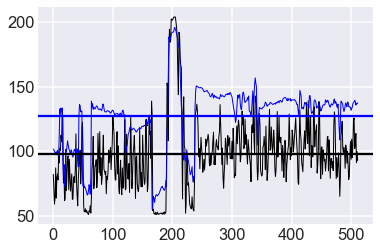

In [64]:
def show_2cuts(im1, im2):    
    m = int(im_original.shape[0]/2) # middle row

    rgb1 = im1[m, :]
    rgb2 = im2[m, :]
    cut1 = []
    cut2 = []
    for key in rgb1:
        i = np.mean(key)
        cut1.append(i)
    for key in rgb2:
        i = np.mean(key)
        cut2.append(i)
    mean1 = np.mean(cut1)
    mean2 = np.mean(cut2)
    plt.figure()
    plt.plot(cut1, c='k', linewidth=1)
    plt.plot(cut2, c='b', linewidth=1)
    plt.axhline(y=mean1,color="black")
    plt.axhline(y=mean2,color="blue")
    difference = mean1 - mean2
    print("Difference",difference)
    return difference
delta = show_2cuts(im_original, im_anime)

Die Helligkeit des Anime-Bildes wird im folgenden Bildpaar reduziert, und die aktuelle Differenz ist ungefähr null:

Difference 0.171875
0.171875


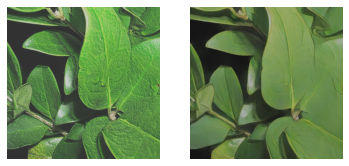

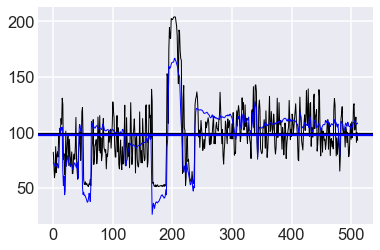

In [65]:
im_animex = im_anime+delta
im_animex = im_animex.astype('uint8')
plt.figure()
plt.subplot(1,2,1)
plt.axis('off')
plt.imshow(im_original)
plt.subplot(1,2,2)
plt.axis('off')
plt.imshow(im_animex)
newdelta = show_2cuts(im_original, im_animex)
print(newdelta)

Um die Auswirkung der Detailgrad auf die Qualität des verrauschten Bildes zu untersuchen, wir wählen Originalbilder mit unterschiedlichen Anzahl von Einzelheiten aus und wandeln sie in Animation um. Wir haben die Bilder je nach Detailgrad in drei Gruppen eingeteilt:

- Gruppe 1: Fotos mit vielen Details (Datei größer als 500 kb)
- Gruppe 2: Fotos mit mittleren Details (Datei zwischen 300 kb und 418 kb)
- Gruppe 3: Fotos mit nur wenigen Details (Datei kleiner als 187 kb)

Nach der Gruppenverteilung merken wir uns, dass die Bilder in einer Gruppe sind, sich in einem bestimmten Bereich von Dateigrößen liegen.

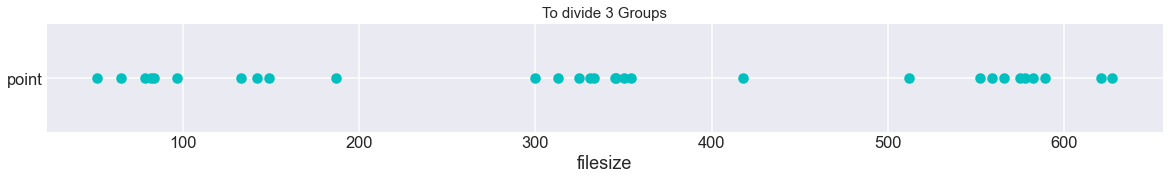

In [66]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# import dataset and convert it into a format that is convenient for drawing
Dataset = pd.read_csv('size.csv')
group = Dataset.groupby(['filesize','Difference']).agg('mean').reset_index()
group1 = Dataset['filesize']

# draw a one-dimensional scatter plot
def plot_one_dim(x, xLabel=None, yLabel=None, color=None):
    
    C = max(x) - min(x)
    fig = plt.figure(figsize=(20, 2))     
    N = len(x)
    # Assign a value of 0 to the Y coordinate
    y = np.zeros(N)    
    
    # draw scatter
    ax = fig.add_subplot(111, frameon=True, yticks=[])    
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)    
    ax.scatter(x,y,c=color)
    ax.yaxis.set_ticks_position('left')
        
    # Display 0 of y coordinate as yLabel
    if yLabel is not None:
        plt.yticks([0],[yLabel])
    
    # Display xLabel
    if xLabel is not None:
        ax.set(xlabel=xLabel)
    
    # Set the y-axis range
    plt.ylim((-1, 1))   
    plt.title("To divide 3 Groups", loc='center', fontsize=15, fontweight=0)
    plt.show()

# set style
plt.style.use('seaborn-darkgrid')
plot_one_dim(group1.values, "filesize", "point","c")


![](divide3.png)


Danach fügen wir jedem Original und Anime-Bild 5 bis 45 Rauschstufen hinzu:

Beispiel von Gruppe 3 (wenig Detailgrad): 

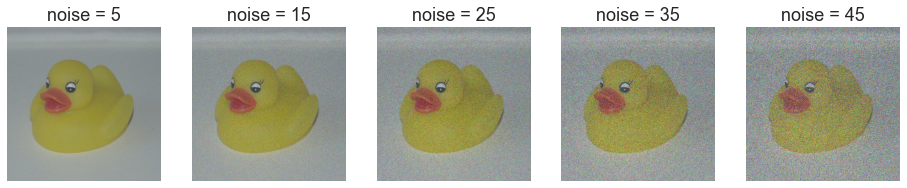

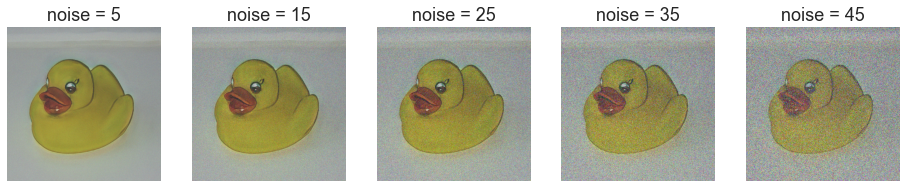

In [61]:
original = Image.open('orig3p1.png')
anime = Image.open('anig3p1.png')
im_original = np.array(original)
im_anime = np.array(anime)

sigma = [5, 15, 25, 35, 45]

plt.figure(figsize=(16, 8))
for i, q in enumerate(sigma):
    noise = np.random.normal(loc=0, scale=q, size=im_original.shape)
    im_e1 = im_original + noise 
    im_e1 = im_e1.astype('uint8')
    plt.subplot(1,5,i+1)
    plt.imshow(im_e1)
    plt.axis('off')
    plt.title('noise = %d' % q)

plt.figure(figsize=(16, 8))
for i, q in enumerate(sigma):
    noise = np.random.normal(loc=0, scale=q, size=im_original.shape)
    im_e2 = im_anime + noise
    im_e2 = im_e2.astype('uint8')
    plt.subplot(1,5,i+1)
    plt.imshow(im_e2)
    plt.axis('off')
    plt.title('noise = %d' % q)
    




Beispiel von Gruppe 2 (mittel Detailgrad): 
![](output_8_0.png)


Beispiel von Gruppe 1 (hoch Detailgrad):
![](output_7_0.png)
![](output_7_1.png)

## 3. Ergebnisse

Die folgende Abbildung zeigt die Wahrnehmungsskalen für unsere Stimuli und zwei Beobachter (der Autor und ein naiver Teilnehmer).

Für verschiedenen Bildtype weisen die Skalen der beiden Beobachtegruppen geringfügige Unterschiede auf. Und egal für welche Versuchspersonen ist festzustellen, dass die Bewertungen für Anime und Original sind bei jedem noise level sehr ähnlich, der Effekt der anive-Konvertierung auf die Rauschwirkung nicht einfach zu bemerken werden kann.

Für verschiedenen Bilddetailgrad weisen die Skalen der beiden Beobachtegruppe aber größere Unterschiede auf. Wir haben festgestellt, egal für experte Person oder naive Person, dass verschiedene Gruppen unterschiedlich bewertet werden. Die Bilder mit höhere Detailgrad besitzen auch bessere Bewertung. Damit wirkt die Detailsgrad im Bild sich selbst auf den Rauscheffekt aus.

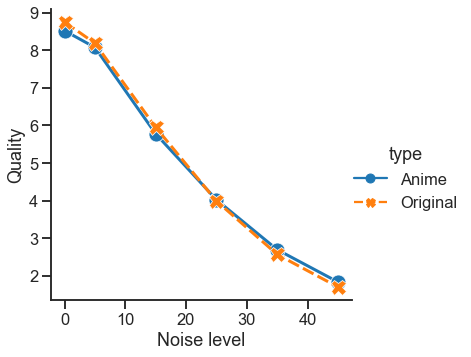

In [7]:
newdata = pd.read_csv('newdata.csv')


g = sns.relplot(x='noise', y='response', data=newdata, 
                hue='type',kind='line', ci = None, markers=True, 
                style='type', linewidth = 3, markersize=15)
g.set_ylabels('Quality')
g.set_xlabels('Noise level')

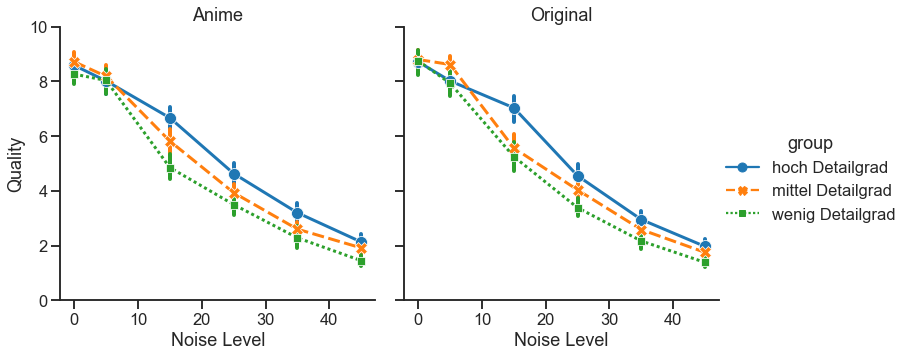

In [8]:
g = sns.relplot(x='noise', y='response', data=newdata, hue='group',
                col='type',kind='line',ci=95,markers=True, err_style='bars',
                style='group', linewidth = 3, markersize=12, err_kws={'elinewidth':4})
g.set_ylabels('Quality')
g.set_xlabels('Noise Level')
g.set_titles('{col_name}')
g.set(ylim = (0, 10))

## 4.Statistical analysis

## 5. Diskussion

Wir stellen fest, dass die Wahrnehmungsskalen für beide Beobachter flach (oder leicht negativ) sind bis zu einem Verzerrung von 60 - 80 (Qualität von 20 - 40). Die Flachheit der Skala in diesem Bereich deutet darauf hin, dass die wahrgenommene Verschlechterung der Bildqualität nicht spürbar ist. Bei Degradationswerten höher als 60 - 80 (Qualität niedriger als 20 - 40) steigen die Wahrnehmungsskalen monoton an, was darauf hinweist, dass die Bildqualität abnimmt und dies von den Beobachtern wahrgenommen wird. Diese Ergebnisse stimmen mit unserem informellen subjektiven Eindruck von Qualitätsverschlechterung überein, wenn man die erste Abbildung oben betrachtet.

### Mögliche Probleme 
Eine klare Einschränkung in unserer Arbeit ist die Tatsache, dass wir eine begrenzte Anzahl von Stimuli verwendet haben. Wir haben nur ein Bild pro Kategorie verwendet, wir haben die Wahrnehmungsskalen für nur zwei Beobachter gemessen. 

### Offene Fragen
Da wir einen Unterschied in Abängigkeit vom Bildmaterial gefunden haben, stellt sich nun die Frage, wie sich die Komprimierung auf andere Arten von Bildern (z. B. Landschaften, Kunstwerke) auswirkt. Eine weitere Frage betrifft die Variabilität zwischen den Beobachtern. Es müsste eine grössere Anzahl von Teilnehmern untersucht werden.

### Referenzen
- https://huggingface.co/spaces/akhaliq/AnimeGANv2